In [1]:
import pandas as pd

In [2]:
balanced_data = pd.read_csv('balanced_features.csv')
balanced_data.head(10)

,Having_IP,Have_At_Sign,URL_Length,URL_Depth,Redirection,HTTP_Domain,Tiny_URL,Prefix_Suffix,Iframe,Mouse_Over,Right_Click,Forwarding,Label
0,0,0,1,3,0,0,0,0,1,1,1,1,1
1,0,0,1,5,0,0,0,0,0,0,1,0,0
2,0,0,1,2,0,0,0,0,1,1,1,1,0
3,0,0,1,2,0,0,0,0,0,0,1,0,0
4,0,0,1,2,0,0,0,0,1,1,1,1,0
5,0,0,0,1,0,0,0,0,1,1,1,1,1
6,0,0,1,2,0,0,0,0,1,1,1,1,0
7,0,0,1,3,0,0,0,0,1,1,1,1,1
8,0,0,1,2,0,0,1,0,1,1,1,1,1
9,0,0,1,2,0,0,0,0,1,1,1,1,0


In [3]:
balanced_data.columns

Index(['Having_IP', 'Have_At_Sign', 'URL_Length', 'URL_Depth', 'Redirection',
       'HTTP_Domain', 'Tiny_URL', 'Prefix_Suffix', 'Iframe', 'Mouse_Over',
       'Right_Click', 'Forwarding', 'Label'],
      dtype='object')

In [4]:
balanced_data.shape

(10000, 13)

In [5]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
balanced_data.head()

,Having_IP,Have_At_Sign,URL_Length,URL_Depth,Redirection,HTTP_Domain,Tiny_URL,Prefix_Suffix,Iframe,Mouse_Over,Right_Click,Forwarding,Label
0,0,0,1,5,0,0,1,1,1,1,1,1,1
1,0,0,1,3,0,0,0,0,1,1,1,1,0
2,0,0,1,2,0,0,0,0,1,1,1,1,1
3,0,0,1,5,0,0,0,1,1,1,1,1,1
4,0,0,1,5,0,0,0,0,0,0,1,0,0


In [6]:
# Separate features and target
X = balanced_data.drop('Label', axis=1)  # Features
y = balanced_data['Label']              # Target

X.shape, y.shape

((10000, 12), (10000,))

In [8]:
# Perform train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% - testing, 80% - training
    random_state=42,  # For reproducibility
    stratify=y  # Maintain class distribution
)

X_train.shape, X_test.shape

((8000, 12), (2000, 12))

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy: 0.827125


In [10]:
from xgboost import XGBClassifier

final_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)
final_model.fit(X_train, y_train)
    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1000
           1       0.90      0.74      0.81      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



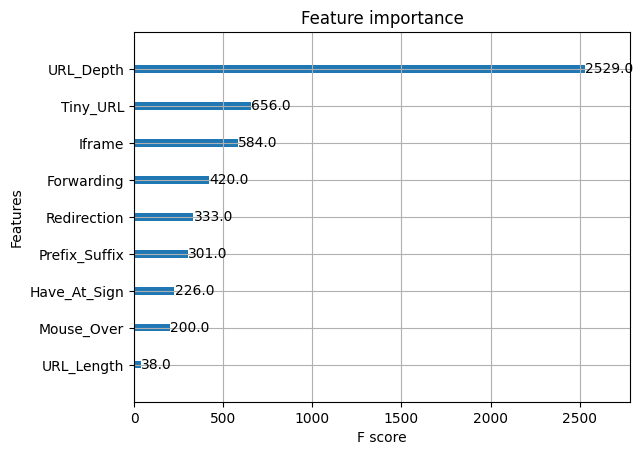

In [12]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(final_model)
plt.show()


In [13]:
import pickle

with open("./models/optimized_xgboost_model.pkl", "wb") as file:
    pickle.dump(final_model, file)
